In [69]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import scipy.stats as stats
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [4]:
# turn off debug to get data
#debug = False

In [5]:
#%run merge-data.ipynb

In [218]:
# or just load merged data for testing
# load primary dataset
df=pd.read_csv('all-merged-data.csv')
allprice=pd.read_csv('allprice.53928.csv', index_col=0, parse_dates=True)
allprice['Date'] = pd.to_datetime(allprice["Date"])

## Q2: Whether there is an impact when clinical trials are withdrawn/suspended

In [8]:
# temporary turn on debug
debug = True

In [9]:
# question related source data overview
if (debug):
    print('initial data shape: ', df.shape)
    print('total phases:', df['phases'].nunique(), df['phases'].unique())
    print('total status:', df['status'].nunique(), df['status'].unique())
    print('total symbols:', df['symbol'].nunique(), df['symbol'].unique())

initial data shape:  (367, 71)
total phases: 8 ['Early Phase 1' 'Phase 2' 'Phase 1' 'Phase 3' 'Phase 2|Phase 3' nan 'N|A'
 'Phase 1|Phase 2' 'Phase 4']
total status: 11 ['Recruiting' 'Active, not recruiting' 'Completed'
 'Approved for marketing' 'Enrolling by invitation' 'Terminated'
 'No longer available' 'Not yet recruiting' 'Withdrawn' 'Available'
 'Suspended']
total symbols: 152 ['PLRX' 'PPD' 'NVS' 'BCRX' 'GILD' 'REGN' 'SNY' 'DGX' 'VNDA' 'ABBV' 'PFE'
 'IFRX' 'CANF' 'BLDE' 'INO' 'CAPR' 'TRHC' 'CDNA' 'IMAB' 'LLY' 'EIGR' 'AZN'
 'BHVN' 'BMY' 'KPTI' 'TBPH' 'HGEN' 'UNH' 'INCY' 'ALXN' 'BHC' 'CNTG' 'MRKR'
 'BLPH' 'LBPS' 'MEDP' 'MESO' 'ATHX' 'IQV' 'BNTX' 'NVAX' 'IPHA' 'INMB'
 'VSTM' 'JNJ' 'GSK' 'IMUX' 'AIM' 'ECOR' 'BGNE' 'IBRX' 'VERU' 'PSTI' 'WINT'
 'CMRX' 'CTSO' 'EXAS' 'AVIR' 'XAIR' 'KNSA' 'ALVR' 'EDSA' 'HOPE' 'APLS'
 'VTGN' 'CTIC' 'CLOV' 'PTNR' 'LIFE' 'KLDO' 'RDHL' 'PHAR' 'SNDX' 'TAK'
 'DVA' 'MNOV' 'FGEN' 'PHAS' 'PTCT' 'SRNE' 'ALT' 'DRRX' 'CVAC' 'AMPE'
 'ANGN' 'AMRN' 'CRVS' 'VAR' 'BMRA' '

In [219]:
# filter data to keep only relevent data points
q2=df[['symbol','company','phases', 'status','last_update_posted', 'why_stopped']]
q2=q2.dropna(subset=['symbol','status'])

if (debug):
    print('question related data shape: ', q2.shape)
    print('total status:', q2['status'].nunique(), q2['status'].unique())

question related data shape:  (367, 6)
total status: 11 ['Recruiting' 'Active, not recruiting' 'Completed'
 'Approved for marketing' 'Enrolling by invitation' 'Terminated'
 'No longer available' 'Not yet recruiting' 'Withdrawn' 'Available'
 'Suspended']


In [220]:
#symbol performance during trail period using status date: last_update_posted
def getSymbolPerformance(symbol, date):    
    startdate = datetime.strptime(date, "%Y-%m-%d") - timedelta(days=0) # same day
    enddate = datetime.strptime(date, "%Y-%m-%d") + timedelta(days=5)  # 5 days after

    #drange = pd.date_range(start=startdate, end=enddate)
    #df = allprice[(allprice.symbol==symbol) & (allprice.index.isin(drange))]
    df = allprice[(allprice.symbol==symbol) & (allprice.Date >= startdate) & (allprice.Date <= startdate)].sort_values('Date')
    if (df.empty):
        return None
    else:
        startprice = df.iloc[0].Open
        endprice = df.tail(1).Close.values[0]
        return 100*(endprice-startprice)/startprice

#getSymbolPerformance('ABC','2020-02-10')

In [221]:
# all symbol performance
q2['performance'] = q2.apply(lambda x: getSymbolPerformance(x.symbol, x.last_update_posted), axis=1)
q2 = q2.dropna(subset=['symbol','performance'])

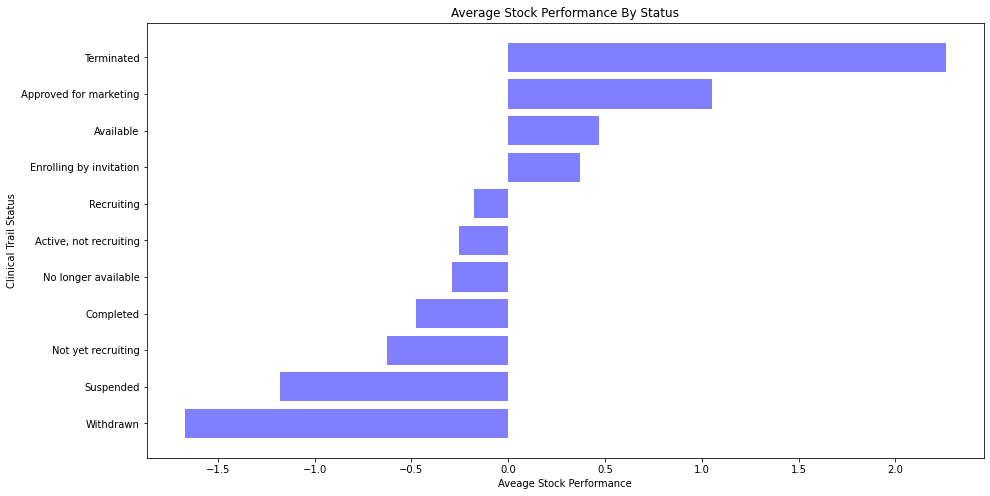

In [222]:
def averageBarChart(df):

    avgdf = df.groupby('status').mean('performance').sort_values('performance')    

    plt.gcf().set_size_inches(15, 8)    
    plt.title("Average Stock Performance By Status")
    plt.barh(avgdf.index, avgdf["performance"], label="Average Performance", color="blue", alpha=0.5)
    plt.xlabel("Aveage Stock Performance")
    plt.ylabel("Clinical Trail Status")
    #plt.legend(loc=0, frameon=True, title="")

    plt.show()
    return

averageBarChart(q2)

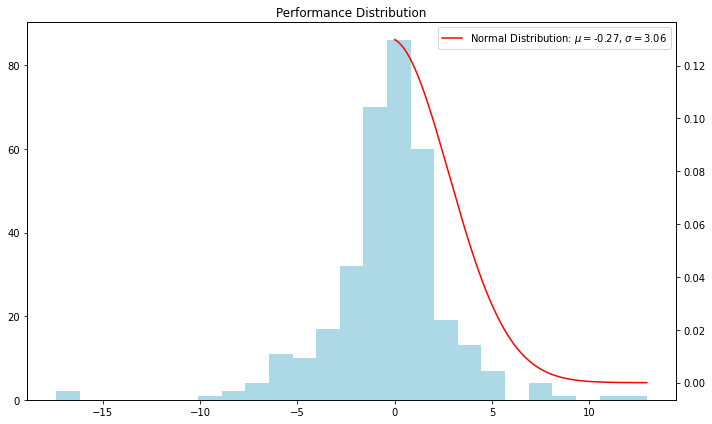

In [223]:
def histgramChart(df):
    dduration = df["performance"]
    mean, std, max = dduration.mean(), dduration.std(), dduration.max()

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.title("Performance Distribution")

    bins = 25
    ax.hist(dduration, bins, color="lightblue", label="Performance")

    # overlay a normal distribution
    ax1 = ax.twinx()
    x = np.linspace(0, max, 1000)
    y = stats.norm.pdf(x, mean, std)
    ax1.plot(x, y, color="r")
    ax1.legend(
        [
            "Normal Distribution: $\mu=$"
            + np.around(mean, 2).astype(str)
            + ", $\sigma=$"
            + np.around(std, 2).astype(str)
        ],
        loc=0,
    )

    fig.tight_layout()
    plt.show()
    return


histgramChart(q2)

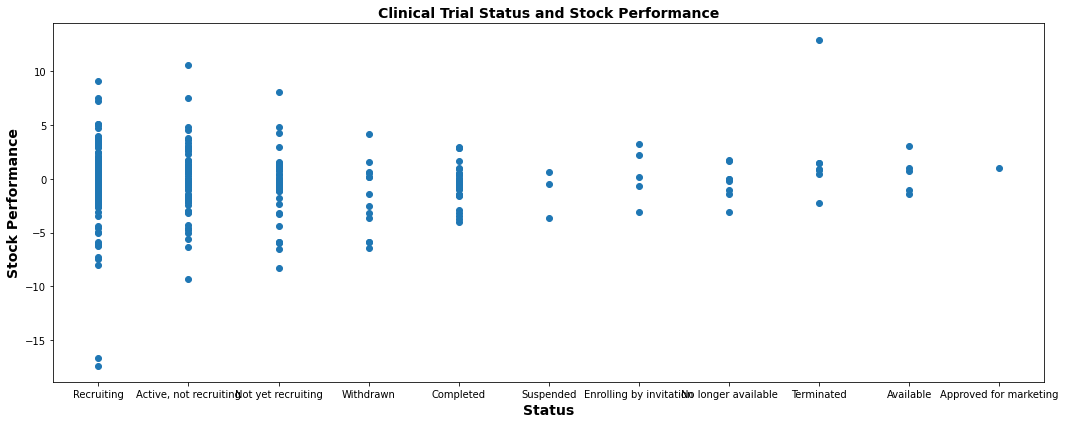

In [224]:
# visualization
def scatterChart(dx, dy, title):
    fig, ax = plt.subplots() 
    plt.gcf().set_size_inches(15,6)

    ax.scatter(dx, dy)
    #ax.plot(dx,dy)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Status", fontsize=14, fontweight='bold')
    ax.set_ylabel("Stock Performance", fontsize=14, fontweight='bold')    
    #ax.set_xticklabels(data.infection_case,rotation=75,horizontalalignment='right',fontweight='light',fontsize='large')

    fig.tight_layout()
    plt.show()
    return

title = 'Clinical Trial Status and Stock Performance'
q2=q2.sort_values('performance')
scatterChart(q2["status"], q2.performance, title)

<AxesSubplot:xlabel='performance'>

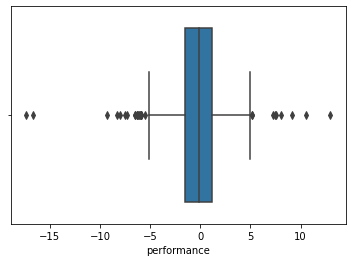

In [225]:
#visualize outliers
sns.boxplot(x=q2['performance'])

In [226]:
# remove outlier 1: z-score <-3 or >3
q2['zscore']=stats.zscore(q2['performance'])
q2['zscore']=stats.zscore(q2['performance'])
threshold1=3
threshold2=-3
q2_z = q2[(q2.zscore<threshold1) & (q2.zscore>threshold2)]
print(q2_z.shape)

(336, 8)


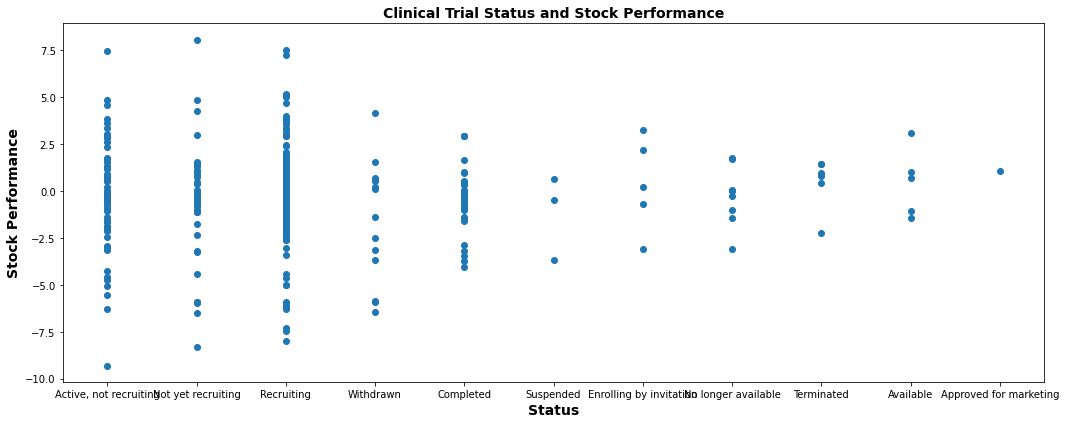

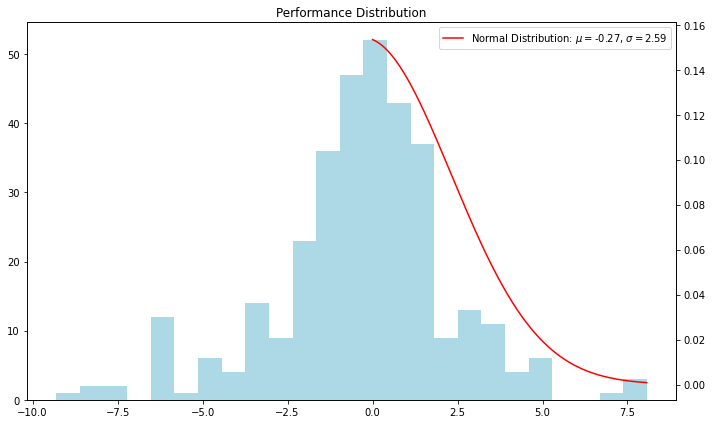

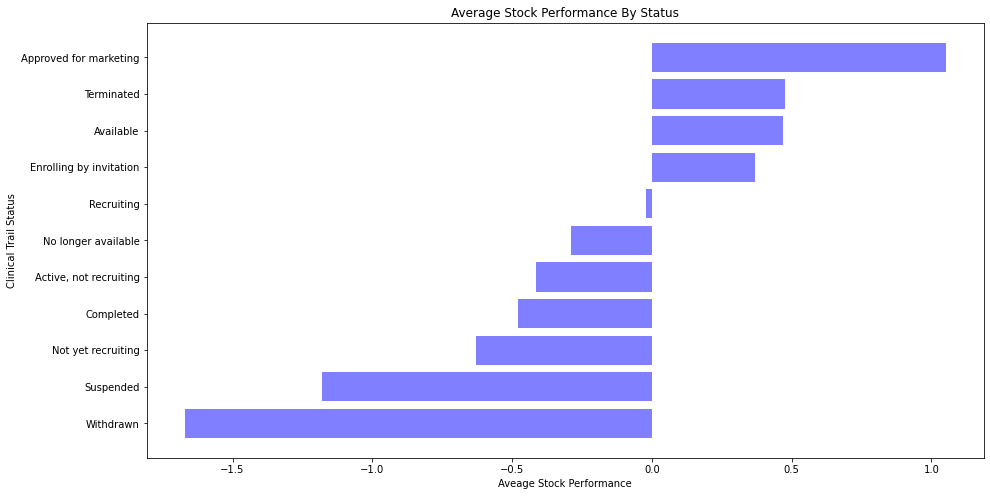

In [227]:
# chart again after removing outlier
scatterChart(q2_z["status"], q2_z.performance, title)
histgramChart(q2_z)
averageBarChart(q2_z)

In [229]:
# # explore corelation
# cort=q2.corr(method='pearson')
# print(q2.describe())
# print(cort)

# cort=q2_z.corr(method='pearson')
# print(q2_z.describe())
# print(cort)

In [230]:
# take a detailed look of withdrawn and suspended trails
q2[q2.status=='Withdrawn'].sort_values('performance')

,symbol,company,phases,status,last_update_posted,why_stopped,performance,zscore
178,RDHL,RedHill Limited,Phase 1|Phase 2,Withdrawn,2020-08-11,To be replaced with a randomized placebo-contr...,-6.465066,-2.026791
253,EQ,Equillium|Biocon Limited,Phase 3,Withdrawn,2021-01-27,Sponsor has currently elected to withhold stud...,-5.901115,-1.842182
42,KPTI,Karyopharm Inc,Phase 2,Withdrawn,2020-12-07,No participants enrolled,-5.867375,-1.831138
244,SRNE,Sorrento,Phase 1|Phase 2,Withdrawn,2021-02-12,Different study will be conducted,-3.681387,-1.115559
86,EIGR,Eiger BioPharmaceuticals,Phase 2,Withdrawn,2021-02-26,Due to the number of competing trials at their...,-3.142856,-0.939273
139,SRNE,Sorrento,Phase 1,Withdrawn,2021-01-08,Difficulty recruiting,-2.490171,-0.725617
157,BMY,Bristol-Myers Squibb,Phase 1|Phase 2,Withdrawn,2020-07-20,Funding,-1.376682,-0.361119
100,HOPE,Hope Pharmaceuticals,Phase 2,Withdrawn,2020-09-16,No recruitment,0.126106,0.130815
39,INCY,Incyte,Phase 2,Withdrawn,2020-05-21,Could not make FDA required changes,0.192915,0.152685
110,PFE,Pfizer,Phase 2,Withdrawn,2020-07-31,Due to the pursuit of other SARS-CoV-2-related...,0.522459,0.260560


In [231]:
q2[q2.status=='Suspended'].sort_values('performance')

,symbol,company,phases,status,last_update_posted,why_stopped,performance,zscore
116,SNDX,Syndax Pharmaceuticals,Phase 2,Suspended,2020-08-11,"Given enrollment challenges, partly attributab...",-3.660133,-1.108602
216,AZN,AstraZeneca|Iqvia |Covance,Phase 3,Suspended,2021-02-11,Study has been suspended due to the occurrence...,-0.496623,-0.073034
217,IQV,AstraZeneca|Iqvia |Covance,Phase 3,Suspended,2021-02-11,Study has been suspended due to the occurrence...,0.620892,0.292782


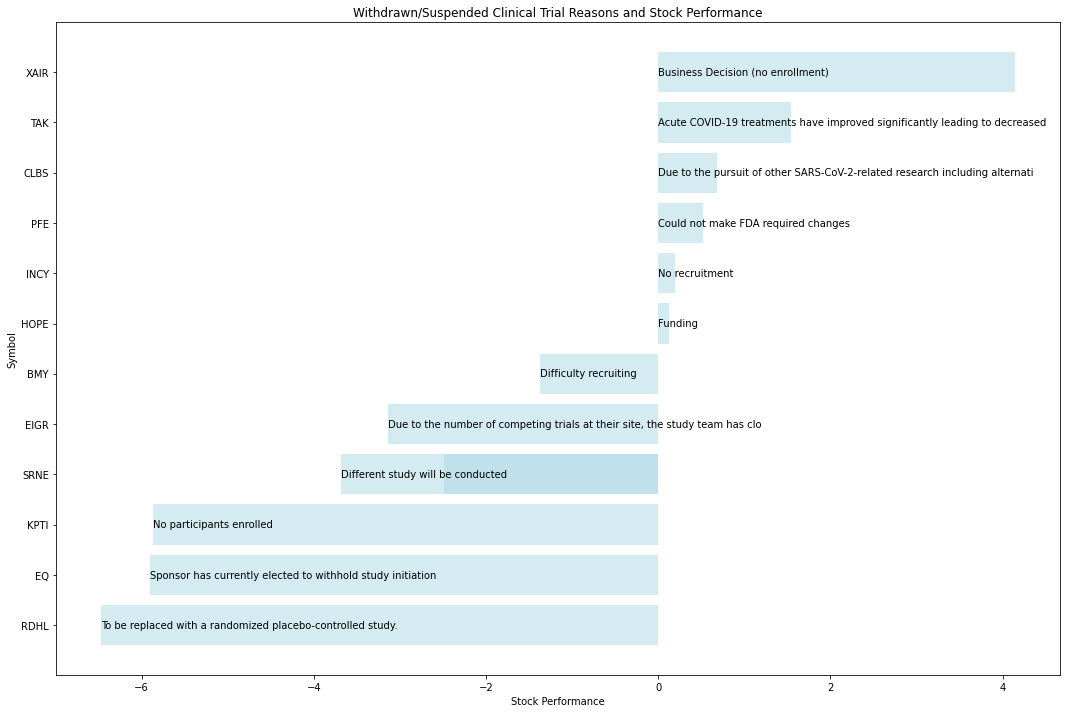

In [232]:
# show withdrawn trails stopped reason
q2why = q2[q2.status=='Withdrawn'].sort_values('performance')
#q2why = q2[q2.status=='Suspended'].sort_values('performance')
#q2why = q2[(q2.status=='Withdrawn')|(q2.status=='Suspended')].sort_values('performance')
bar_label = q2why.why_stopped.tolist()

def autolabel(ax, rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        width = rect.get_width()        
        if (width < 0):
            xstart = width
        else:
            xstart = 0        
        #print(idx, bar_label[idx])
        ax.text(xstart, rect.get_y() + height/2,
                bar_label[idx][:75],
                ha='left', va='center')

def whyBarChart(df):    
    fig, ax = plt.subplots() 
    plt.gcf().set_size_inches(18,12)

    bar_plot = plt.barh(df.symbol, df.performance, label="perrformance", color="lightblue", alpha=0.5)
    #plt.yticks([], []) #remove y ticks
    autolabel(ax, bar_plot)

    plt.xlabel("Stock Performance")
    plt.ylabel("Symbol")   
    plt.title('Withdrawn/Suspended Clinical Trial Reasons and Stock Performance')
    plt.show()
    
whyBarChart(q2why)